# Searching for the spike at 306Hz

https://www.kaggle.com/c/g2net-gravitational-wave-detection/discussion/263995

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import signal
import torch
import torchaudio
from tqdm.notebook import tqdm
from torch.fft import fft, rfft, ifft
from nnAudio import Spectrogram
import pywt
from pathlib import Path

COMP_NAME = "g2net-gravitational-wave-detection"

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/{COMP_NAME}/")
OUTPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_output/{COMP_NAME}/")

plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
df = pd.read_csv(INPUT_PATH / "training_labels.csv")
print(df.shape)
df.head(10)

(560000, 2)


,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
5,0000bb9f3e,1
6,0000c3b9c9,0
7,0000d61b7b,1
8,0001016d12,1
9,00010beb4a,1


In [3]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from PIL import Image

In [4]:
def read_file(id_, folder="train"):
    path = INPUT_PATH / folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
    data = np.load(path)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
    return d1, d2, d3

def plot_time_data(d1, d2, d3):
    plot = Plot(d1, d2, d3, separate=True, sharex=True, figsize=[12, 8])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plot.show()
    
def idx_from_id(id_):
    return df.query(f"id == '{id_}'").index[0]

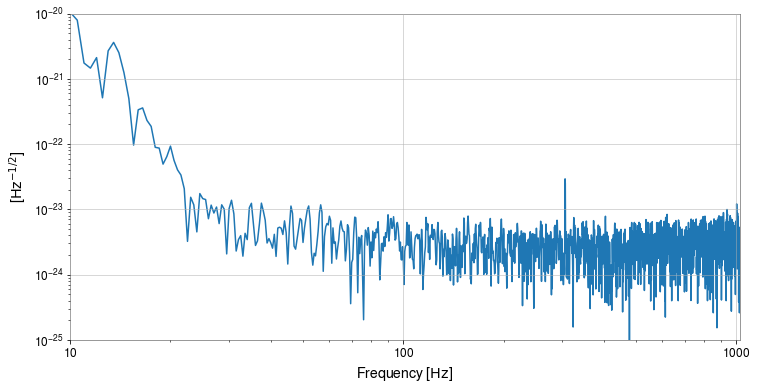

In [5]:
d1, d2, d3 = read_file(df.loc[4, "id"])

# Window function
window = signal.tukey(4096)

d1, d2, d3 = d1*window, d2*window, d3*window
# plot_time_data(d1, d2, d3)

fig2 = d1.asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

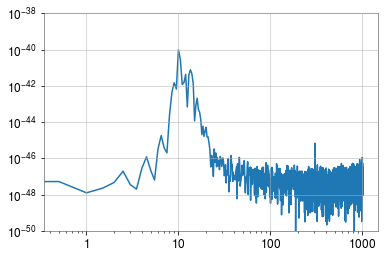

In [6]:
freq, pxx = signal.periodogram(np.array(d1), fs=2048)

plt.plot(freq, pxx);
plt.ylim([1e-50, 1e-38])
plt.xscale('log')
plt.yscale('log')

In [7]:
pxx[100:]

array([1.12946761e-47, 1.48783735e-47, 1.53869230e-47, ...,
       5.46354653e-48, 1.63608866e-47, 5.06329350e-48])

In [8]:
freq[500], freq[700]

(250.0, 350.0)

In [9]:
freq[np.argmax(pxx[100:]) + 100]

306.0

In [23]:
def load_file(id_, folder="train", norm=False):
    path = INPUT_PATH / folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
    waves = np.load(path)
    # return waves / np.max(waves, axis=1).reshape(3, 1)
    if norm:
        return waves / np.max(waves)
    else:
        return waves

def plot_periodogram(data, channel=0):
    freq, pxx = signal.periodogram(data[channel], fs=2048)

#     plt.figure(figsize=(20, 10))
    plt.plot(freq[20:], pxx[20:])
    plt.ylim([1e-50, 1e-38])
    plt.xscale('log')
    plt.yscale('log')


def get_spike(x, lb=250, ub=350):
    spikes = []
    for ch in x[:2]:
        freq, pxx = signal.periodogram(ch, fs=2048)
        freq = freq[lb * 2: ub * 2]
        pxx = pxx[lb * 2: ub * 2]
        spikes.append(freq[np.argmax(pxx)])
    return spikes

[306.0, 306.0]


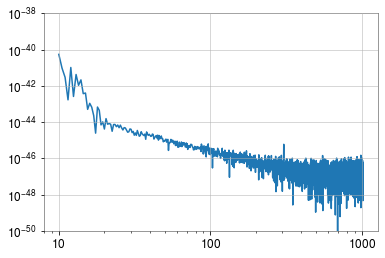

In [24]:
data = load_file("ffff9a5645")

plot_periodogram(data, 0)
print(get_spike(data))

In [12]:
ch1_spikes, ch2_spikes = [], []
for id_ in tqdm(df["id"]):
    data = load_file(id_)
    a, b = get_spike(data)
    ch1_spikes.append(a)
    ch2_spikes.append(b)
    
df["ch1_spikes"] = ch1_spikes
df["ch2_spikes"] = ch2_spikes

In [13]:
df["ch1_spikes"].value_counts()

306.5    275341
306.0    222019
305.5     21299
307.0      6125
305.0      1016
          ...  
344.5        39
341.5        37
345.5        37
333.5        36
336.0        33
Name: ch1_spikes, Length: 200, dtype: int64

In [14]:
df["has_ch1_spike"] = df["ch1_spikes"].between(305, 307)
df["has_ch2_spike"] = df["ch2_spikes"].between(305, 307)
df["has_both_spike"] = df["has_ch1_spike"] & df["has_ch2_spike"]

In [15]:
df["has_ch1_spike"].value_counts()

True     525800
False     34200
Name: has_ch1_spike, dtype: int64

In [16]:
df["has_ch2_spike"].value_counts()

True     525867
False     34133
Name: has_ch2_spike, dtype: int64

In [17]:
df["has_both_spike"].value_counts()

True     493779
False     66221
Name: has_both_spike, dtype: int64

# Notch filter

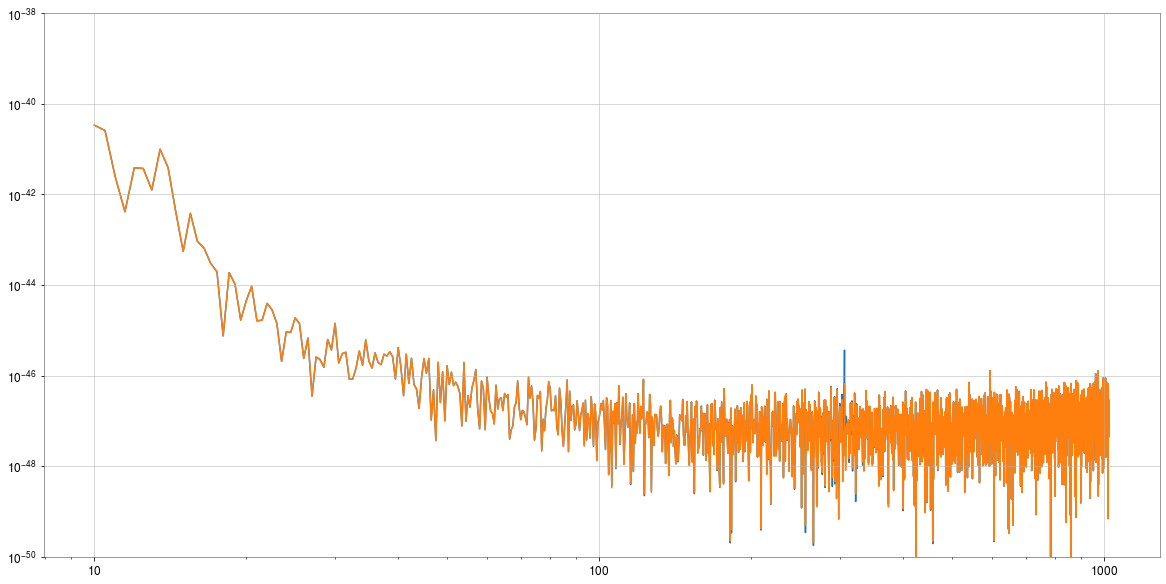

In [32]:
data = load_file(df.loc[1, "id"])

b, a = signal.iirnotch(306, 306, fs=2048)
plot_periodogram(data, 0)

data = signal.filtfilt(b, a, data)

plot_periodogram(data, 0)